# DTSA 5511 Mini-Project: Monet GANs

---

### Contents
1. Introduction
2. Imports and environment setup
3. Description of the data
4. Model architecture
5. Results and analysis
6. Conclusion

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

https://keras.io/examples/generative/cyclegan/

https://www.tensorflow.org/tutorials/generative/cyclegan

---

### 1. Introduction
In this project we will use Generative Adversarial Networks to process images. More specifically, we will train a GAN on paintings by Monet, then ask it to transform modern photographs into a style that resembles Monet's. One of the earliest and most impressive demonstration of generative AI has been in this area - making images in the style of an existing artist. Here we will create this capability from scratch in order to better understand how it works.

A GAN is a deep learning architecture that consists of two neural networks, the generator and the descriminator, which face off in a turn-by-turn game-like setting. The generator tries to trick the generator into believing that the data it has created is real, while the discriminator tries to pick out the generator's fake data. After each round of the game, the two competing neural networks learn from their mistakes and update their weights via back propagation. Over the course of many rounds of competition and improvement, the generator becomes very good at creating "fake" data that resembles the target, helped by a discriminator which has become very good at telling real from fake.

This approach can be used to create synthetic data in many forms, but in this project, we will use it to images. We will train the GAN on images of paintings by Monet, with the goal that the neural networks will learn a representation of the essence of Monet's style, ie: what it means to "be a Monet". This is difficult to explain to a human in plain English, let alone to do it precisely enough for a computer to interpret. The benefit of the GAN approach is that we let the two neural networks teach eachother, letting them evolutionarily derive what it means to "be a Monet" in terms a computer can understand.

The data we will use in this project comes from the Kaggle challenge titled "I'm Something of a Painter Myself". It is part of their "Getting Started" code competitions and serves as their introduction to GANs. https://www.kaggle.com/competitions/gan-getting-started/overview

As suggested in the assignment, the code we will use was adapted from Amy Jang's Kaggle notebook "Monet CycleGAN Tutorial". https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial It provides a nicely structured and clearly explained implementation of the popular CycleGAN architecture.

CycleGAN is a deep neural network architecture that was specifically designed for image-to-image translation tasks like this Monet assignment. It was published in the paper "Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks" by Jun-Yan Zhu et al in 2017 https://arxiv.org/abs/1703.10593. The innovative feature of CycleGAN is that it does not require paired images to map between. By using two separate GANs in a cycle, it learns to map both from the source domain to the target domain, and from the target domain back to the source domain, allowing to learn from sets of images that are not strictly paired 1-to-1.

We will use the photographs and images of Monet paintings included in the Kaggle competition's data set to train a CycleGAN, use that GAN to generate images "in the style of Monet", then submit those images to Kaggle for scoring.

---

### 2. Imports and Env Setup

In [ ]:
from google.colab import userdata, files, drive
# drive.mount('/content/drive')
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
import kaggle

In [ ]:
%%time
# !mkdir /root/.kaggle
# !cp /content/drive/MyDrive/kaggle/kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle competitions download -c gan-getting-started
!unzip -o -q /content/drive/MyDrive/kaggle/monet_gan/gan-getting-started.zip -d /content/gan_data/

CPU times: user 27.5 ms, sys: 5.94 ms, total: 33.4 ms
Wall time: 4.53 s


In [ ]:
! pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from joblib import dump, load
import plotly.express as px
import plotly.graph_objects as go

import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Device: 
Number of replicas: 8
2.15.0


---
### 3. Description of the Dataset

The dataset consists of 300 images of Monet paintings and 7000 photographs of unknown origin. The photos seem to be mostly landscapes and cityscapes, which is a good fit to be transformed into a Monet style.

As downloaded, the data has both sets of images in jpeg format, as well as TFRecord format. TFRecord is a format for storing binary data in a way that is easy for TensorFlow to interact with. We will use the TFRecord format here.

To see the type of images in the dataset, we will display a sample image from the photos folder and one from the Monet folder.

In [ ]:
img_path = '/content/gan_data'
MONET_FILENAMES = tf.io.gfile.glob(str(img_path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(img_path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

### Take a look at a sample image from both sets.

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

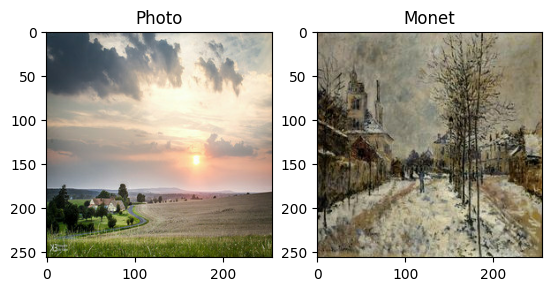

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5);

---
### 4. Model Architecture

In CycleGAN, there are two generator/discriminator pairs. The role of the generators is to translate images from one domain to another. In the original CycleGAN paper, this was horses to zebras, in our project it is photographs to Monet paintings. The discriminator's job is to decide which domain a particular image file belongs to.

The downsample and upsample functions below serve to add convolutional and reverse convolutional layers to the generator and discriminator models. Downsampling serves as a feature extraction function, while upsampling is used by the generators to increase the resolution of a downsampled representation until it matches the high-quality images of the target domain.

The main CycleGAN class creates the two generator/discriminator pairs and coordinates the iterative generation/evaluation turns. The high level flow is that the first generator takes an image from the photo domain and attempts to transform it into an image that matches the Monet domain. Similarly, the second generator takes an image from the Monet domain and attempts to transform it into an image in the photo domain.

The next step is critical to the cyclic nature of CycleGAN. The two generated images are then fed into the other GAN (the one that did not generate it) to attempt to reconstruct the original image.

Then the discriminators evaluate their corresponding generated images to determine the adversarial loss. This loss is used to push the generators to create images that better match the target domain.

The next step is again unique to CycleGAN, which is to calculate the cycle consistency loss. This is the difference between a generated image and its reconstructed original and is what pushes the neural networks to perform well in both directions, eliminating the need for paired images.

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

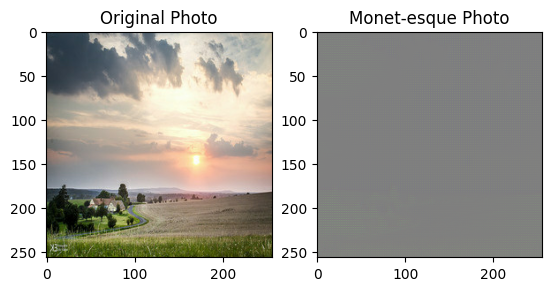

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

In [ ]:
class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

---
### 5. Results and Analysis

In this section we will use the model architecture developed above to train a model on the Kaggle dataset, then generate and submit images to the competition.

After using the default settings in Amy Jang's notebook running out to 50 epochs, I noticed the models failed to improve after 20 or so epochs. To address this I added an exponential decay learning rate scheduler.

Summary of the three training runs and results.

__Run 1__
- 50 epochs, exponential decay LR schedule
- Monet gen loss decreases until around epoch 20, then starts to climb
- Images show some artifacting (I suppose this is the "Monet style")
- Kaggle score: 53.89 (39th out of 131 on the public leaderboard)

After Run 1, I noticed the Monet generator loss reached a minimum around epoch 20 and climbed from there until the end of training at epoch 50. To combat the overfitting this will cause in the final model, I decided to implement an early stopping callback on the Monet generator loss.

__Run 2__
- 50 epochs, exponential decay LR schedule, early stopping
- Early stopping stopped training at epoch 23
- Images show less artifacting than 50-epoch model
- Kaggle score: 65.25 (lower is better, this is worse than Run 1)

I was hoping Run 2 would result in an improvement in our Kaggle score, but the opposite happened - Run 1 was better. Comparing the generated images between Runs 1 and 2, Run 1 has more visual artifacting than Run 2 images. This makes sense since we ran Run 1 for twice as many epochs. So while the Monet generator loss scores are better for Run 2 than Run 1, the Kaggle scorer seems to prefer more artifacting. We'll follow this logic and increase the number of epochs to 300.

__Run 3__
- 300 epochs, exponential decay LR schedule, removed early stopping
- Both loss values fluctuated widely until epoch 200, then seemed to converge nicely
- Images show quite a bit more artifacting than Runs 1 and 2
- Kaggle score: 58.02 (lower is better, improved over Run 2 but not better than Run 1)

Looking at the output images, I could tell there was a lot more visual artifacting than in either of the previous runs. The pattern from the previous two runs seemed to indicate that more artifacting means that the GAN is making more changes to the input images and that the Kaggle scorer like this. It's hard to say that the additional artifacts in Run 3 took the input images in a more Monet-like direction, but they certainly add a more unique look. I was hopeful that the Kaggle scorer would agree that these images are more Monet-like, and there was an improvement from Run 2, but Run 1 remains the best one.

### Run 1: Baseline

In [ ]:
with strategy.scope():
    initial_learning_rate = 2e-4
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9)

    monet_generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
epochs = 50
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=epochs
)

Epoch 1/50
300/300 [==============================] - 173s 177ms/step - monet_gen_loss: 5.2279 - photo_gen_loss: 5.3447 - monet_disc_loss: 0.6292 - photo_disc_loss: 0.6248
Epoch 2/50
300/300 [==============================] - 53s 176ms/step - monet_gen_loss: 3.7595 - photo_gen_loss: 3.8619 - monet_disc_loss: 0.6637 - photo_disc_loss: 0.6140
Epoch 3/50
300/300 [==============================] - 53s 177ms/step - monet_gen_loss: 3.6264 - photo_gen_loss: 3.7769 - monet_disc_loss: 0.6506 - photo_disc_loss: 0.6047
Epoch 4/50
300/300 [==============================] - 53s 177ms/step - monet_gen_loss: 3.5351 - photo_gen_loss: 3.7187 - monet_disc_loss: 0.6437 - photo_disc_loss: 0.5978
Epoch 5/50
300/300 [==============================] - 53s 177ms/step - monet_gen_loss: 3.3678 - photo_gen_loss: 3.6144 - monet_disc_loss: 0.6451 - photo_disc_loss: 0.5902
Epoch 6/50
300/300 [==============================] - 53s 177ms/step - monet_gen_loss: 3.3110 - photo_gen_loss: 3.5435 - monet_disc_loss: 0.6259

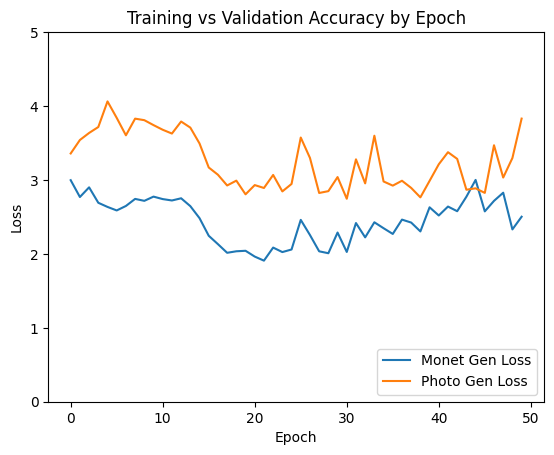

In [ ]:
monet_gen_loss = np.array(history.history['monet_gen_loss']).reshape(epochs, -1).mean(axis=1)
photo_gen_loss = np.array(history.history['photo_gen_loss']).reshape(epochs, -1).mean(axis=1)

plt.plot(monet_gen_loss, label='Monet Gen Loss')
plt.plot(photo_gen_loss, label = 'Photo Gen Loss')
# plt.plot(history.history['monet_disc_loss'], label = 'Monet Disc Loss')
# plt.plot(history.history['photo_disc_loss'], label = 'Photo Disc Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

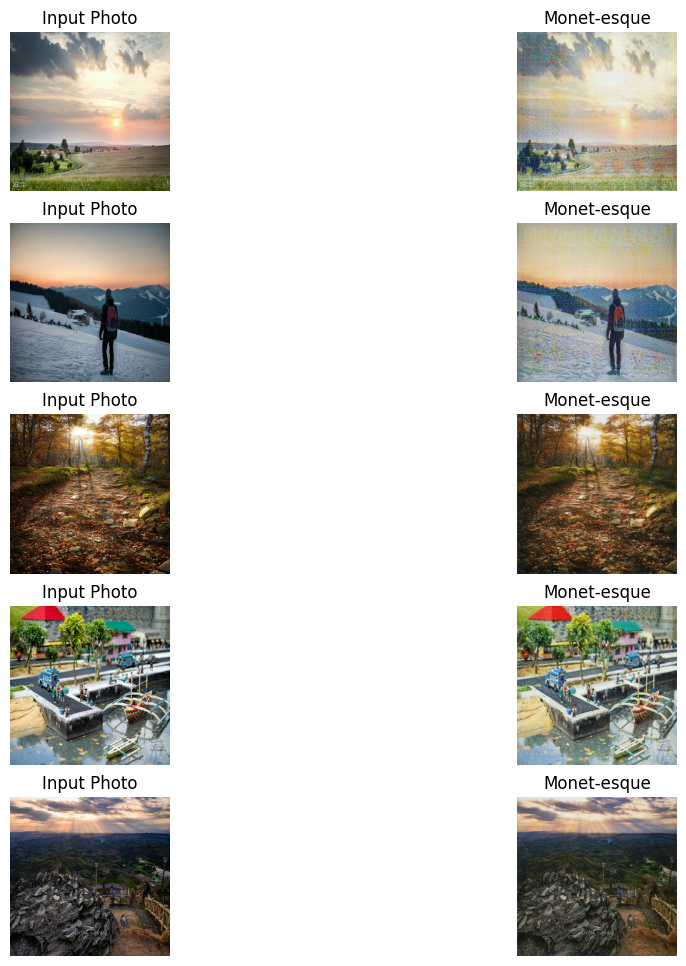

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/content/drive/MyDrive/kaggle/monet_gan/images/02/" + str(i) + ".jpg")
    i += 1

### Run 2: With early stopping

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3)

In [ ]:
epochs = 50
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=epochs
    callbacks=[callback]
)

Epoch 1/23
300/300 [==============================] - 178s 179ms/step - monet_gen_loss: 5.1927 - photo_gen_loss: 5.2688 - monet_disc_loss: 0.6202 - photo_disc_loss: 0.6251
Epoch 2/23
300/300 [==============================] - 54s 179ms/step - monet_gen_loss: 3.6969 - photo_gen_loss: 3.7474 - monet_disc_loss: 0.6516 - photo_disc_loss: 0.6320
Epoch 3/23
300/300 [==============================] - 54s 179ms/step - monet_gen_loss: 3.6449 - photo_gen_loss: 3.7470 - monet_disc_loss: 0.6394 - photo_disc_loss: 0.6094
Epoch 4/23
300/300 [==============================] - 54s 180ms/step - monet_gen_loss: 3.5106 - photo_gen_loss: 3.6498 - monet_disc_loss: 0.6300 - photo_disc_loss: 0.6031
Epoch 5/23
300/300 [==============================] - 54s 180ms/step - monet_gen_loss: 3.3764 - photo_gen_loss: 3.5319 - monet_disc_loss: 0.6197 - photo_disc_loss: 0.6000
Epoch 6/23
300/300 [==============================] - 54s 180ms/step - monet_gen_loss: 3.2853 - photo_gen_loss: 3.4593 - monet_disc_loss: 0.6257

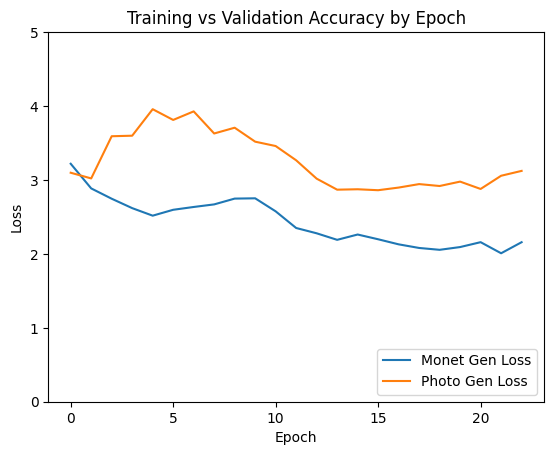

In [ ]:
monet_gen_loss = np.array(history.history['monet_gen_loss']).reshape(epochs, -1).mean(axis=1)
photo_gen_loss = np.array(history.history['photo_gen_loss']).reshape(epochs, -1).mean(axis=1)

plt.plot(monet_gen_loss, label='Monet Gen Loss')
plt.plot(photo_gen_loss, label = 'Photo Gen Loss')
# plt.plot(history.history['monet_disc_loss'], label = 'Monet Disc Loss')
# plt.plot(history.history['photo_disc_loss'], label = 'Photo Disc Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

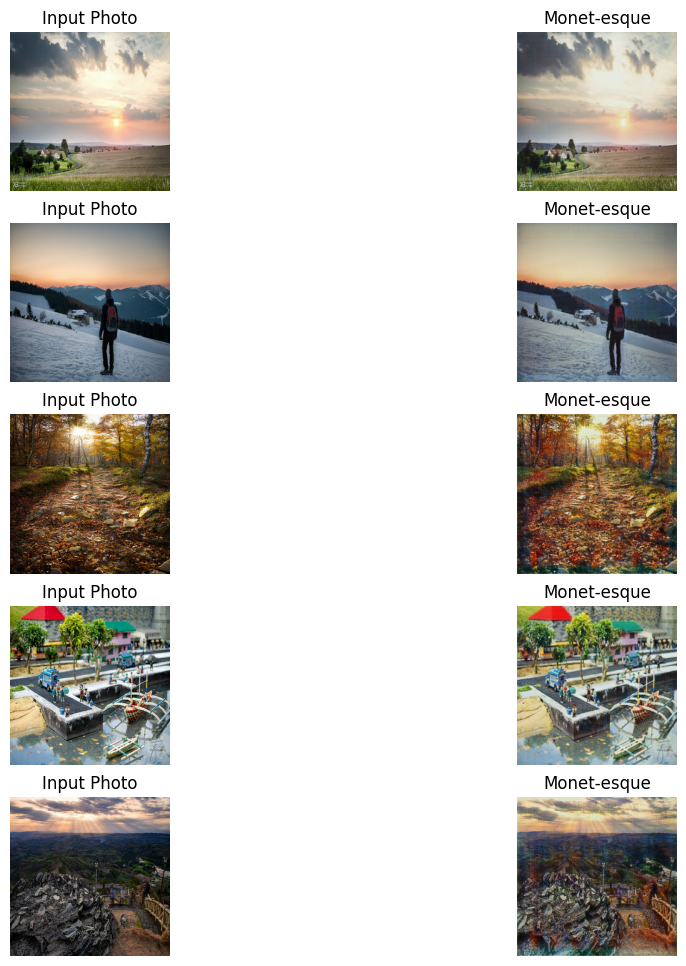

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/content/drive/MyDrive/kaggle/monet_gan/images/03/" + str(i) + ".jpg")
    i += 1

### More epochs

In [ ]:
epochs = 300
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=epochs
)

Epoch 1/300
300/300 [==============================] - 170s 178ms/step - monet_gen_loss: 5.1521 - photo_gen_loss: 5.2781 - monet_disc_loss: 0.6508 - photo_disc_loss: 0.6355
Epoch 2/300
300/300 [==============================] - 53s 177ms/step - monet_gen_loss: 3.6490 - photo_gen_loss: 3.6706 - monet_disc_loss: 0.6594 - photo_disc_loss: 0.6687
Epoch 3/300
300/300 [==============================] - 54s 178ms/step - monet_gen_loss: 3.5194 - photo_gen_loss: 3.5190 - monet_disc_loss: 0.6476 - photo_disc_loss: 0.6649
Epoch 4/300
300/300 [==============================] - 53s 178ms/step - monet_gen_loss: 3.4173 - photo_gen_loss: 3.4246 - monet_disc_loss: 0.6430 - photo_disc_loss: 0.6491
Epoch 5/300
300/300 [==============================] - 53s 178ms/step - monet_gen_loss: 3.2494 - photo_gen_loss: 3.2938 - monet_disc_loss: 0.6408 - photo_disc_loss: 0.6346
Epoch 6/300
300/300 [==============================] - 53s 178ms/step - monet_gen_loss: 3.1175 - photo_gen_loss: 3.1825 - monet_disc_loss: 

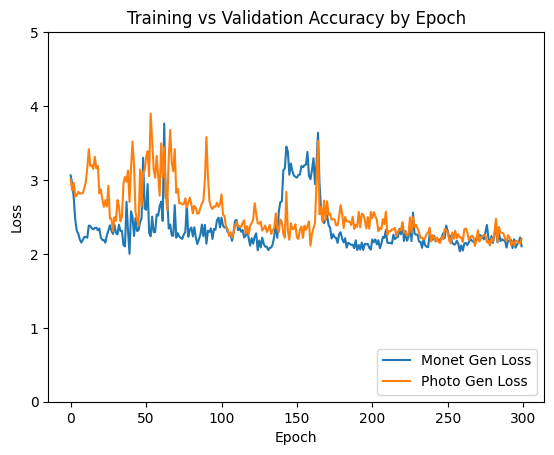

In [ ]:
monet_gen_loss = np.array(history.history['monet_gen_loss']).reshape(epochs, -1).mean(axis=1)
photo_gen_loss = np.array(history.history['photo_gen_loss']).reshape(epochs, -1).mean(axis=1)

plt.plot(monet_gen_loss, label='Monet Gen Loss')
plt.plot(photo_gen_loss, label = 'Photo Gen Loss')
# plt.plot(history.history['monet_disc_loss'], label = 'Monet Disc Loss')
# plt.plot(history.history['photo_disc_loss'], label = 'Photo Disc Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.title('Training vs Validation Accuracy by Epoch')
plt.legend(loc='lower right')
plt.show()

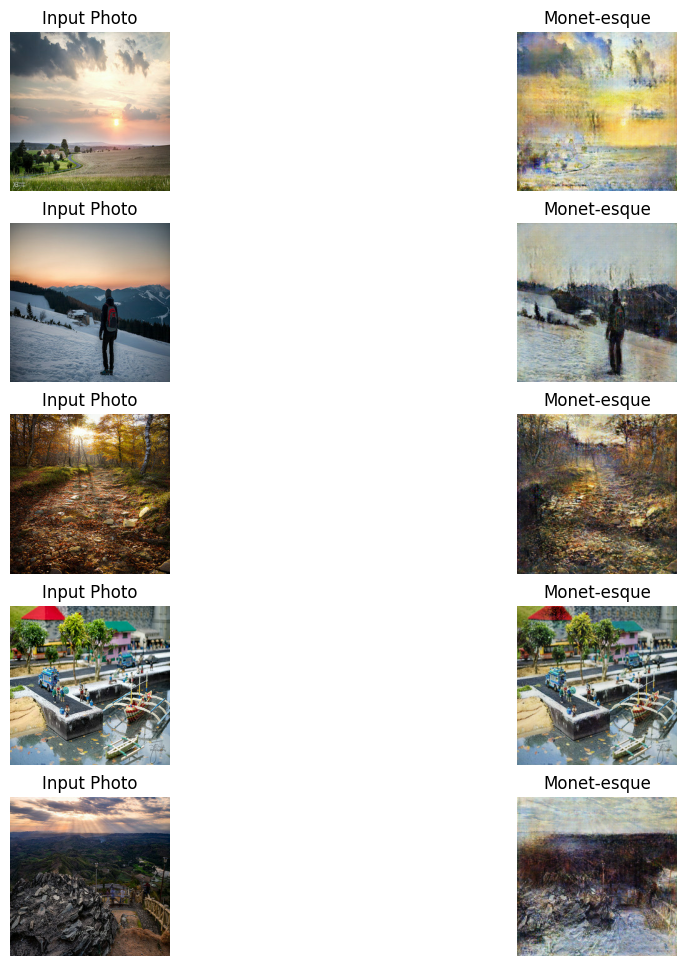

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import PIL
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/content/drive/MyDrive/kaggle/monet_gan/images/04/" + str(i) + ".jpg")
    i += 1

---
### 6. Conclusion

In this project we used the CycleGAN architecture to teach a set of neural networks what it means for an image to be Monet-like, then generated images in the style of Monet to be scored by Kaggle. Here is a summary of the results:

&nbsp;

| Iteration | Epochs | Exponential LR Decay | Early Stopping  | Kaggle Score |
|-----|-----|-------|---|---|
| Run 1 | 50 | Yes | No | 53.89 |
| Run 2 | 23 | Yes | Yes | 65.25 |
| Run 3 | 300 | Yes | No | 58.02 |

&nbsp;

I've always wondered how generative AI models that accepts prompts of the form "generate X in the style of Y" worked. I knew GANs were involved, but I never undestood exactly how until now. Although I was not able to improve my Kaggle score, I really enjoyed working on this project and feel like I've learned a lot. The CycleGAN architecture is quite clever, similar to self-supervision for pairs of GANs.

One issue I have is with the arbitrariness of the Kaggle scorer. Just like it is hard to define what makes an image "Monet-like", we likewise have to rely on the Kaggle scorer's interpretation of what makes a successful image. In a sense, we are hoping that our generator/discriminator pairs independently arrive at the same interpretation of "Monet-ness" as the Kaggle discriminator. Since "Monet-ness" is a highly subjective attribute, the submission process is akin to a very slow, manual training process without the benefit of backprop. Despite this arbitrariness in the scoring, this was overall a very enjoyable project.